##1. Implement BPE Algorithm (4 marks):

Develop a Python implementation of the Byte Pair Encoding (BPE) algorithm, covering key
steps such as learning byte pair merges and encoding/decoding using the learned merge
operations.

In [82]:
from typing import List, Dict
import re
import matplotlib.pyplot as plt

from collections import defaultdict

class BPE():
    def __init__(self, debug=False, vocab=set() ):
        self.vocab = vocab
        # self.bpe_pairs = set()
        self.debug = debug

    def init_corpus(self, data: List[str]):
        """
        Corpus is dict of char tokens to frequency
        """
        corpus = defaultdict(lambda: 0)
        vocab = set()
        #end of word symbol
        vocab.add('_')

        for line in data:
            for word in line.split():
                corpus[' '.join(list(word)) + ' _'] += 1
                vocab.update(list(word))

        return corpus,vocab

    def isStopChar(self,token:str)->bool:
        return bool(re.match('[,.?"\'!;:]+',token))

    def get_pairs(self, corpus: Dict[str, int]):
        pairs = defaultdict(lambda: 0)

        for word, freq in corpus.items():
            tokens = word.split()

            # Pair to frequency, avoiding stop characters
            for i in range(len(tokens) - 1):
              #  if not (self.isStopChar(tokens[i]) or self.isStopChar(tokens[i+1])):
                  pairs[tokens[i], tokens[i + 1]] += freq

        return pairs

    def merge_corpus(self, pair, corpus):
        """
        merge pair appears in the corpus
        """

        corpus_out = {}
        #treat special chars (.*) as normal chars
        bigram = re.escape(' '.join(pair))

        #find pairs allowing spaces for before or at the end
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        for word in corpus:
            word_out = p.sub(''.join(pair), word)
            corpus_out[word_out] = corpus[word]
        return corpus_out


    def save_pair(self, pair, vocab):
        """
        Save merged pair
        """
        vocab.add(''.join(pair))
        # self.bpe_pairs.add(pair)
        return


    def byte_pair_encoding(self, data, k):
        """
        From the given list of strings, merge most frequent adjacent pairs till k times,
        returns vocab, a set of learnt vocab from corpus
        """
        sens = [sentence.strip() + '.' for sentence in data.split('.') if sentence]
        corpus,vocab = self.init_corpus(sens)
        self.merge_freq = []

        for i in range(k):
            pairs = self.get_pairs(corpus)
            if not pairs:
                break

            #most frequent pair
            best = max(pairs, key=pairs.get)

            self.save_pair(best,vocab)

            corpus = self.merge_corpus(best, corpus)

            if self.debug:
                print(f"\n--After {i} iteration")
                print("Most freq pairs: ", best)
                print("Corpus after update: ", corpus)

            self.merge_freq.append((best, pairs[best]))

        # self.corpus = corpus
        self.vocab.update(vocab)

        return self.vocab, corpus


    def decoding(self, tokens:List[chr], vocab)->str:
        """
        decode tokens in sentence and keep merging back to the original sentences using the learned vocab
        """
        if not vocab:
            print("Vocab not learned")
            return

        # Split the data into words, then characters
        decoded = tokens

        is_merged = True
        while is_merged:
            i=0
            is_merged = False

            while i< len(decoded)-1:
                merged = decoded[i]+decoded[i+1]

                if merged in vocab or merged+'_' in vocab:
                    decoded[i] = merged
                    del decoded[i+1]
                    is_merged = True

                else:
                    i+=1

        return decoded

    def visualize_pair_merge_freq(self):
        """
        visualize
        """

        frequencies = [freq for pair, freq in self.merge_freq]
        vocab_size = [i for i, _ in enumerate(self.merge_freq, start=1)]

        plt.figure(figsize=(10, 6))
        plt.bar(vocab_size, frequencies, color='skyblue')
        plt.xlabel('Merged Pairs')
        plt.ylabel('Frequencies')
        plt.title('Frequency of Byte Pair Merges per Iteration')
        plt.xticks(rotation=45)
        plt.show()




In [ ]:
#Test BPE class, encoding, generated vocab
data = "lower low higher"

bpe = BPE(debug=True)
vocab, corpus = bpe.byte_pair_encoding(data,10)

print("\nVocab: ",vocab)
print("Corpus: ",corpus)

tokens = [char for word in data.split() for char in word]
decoded = bpe.decoding(tokens,vocab)
print("Decoding: ",decoded)

## 2.Train on NLTK Dataset (3 marks):
Utilize NLTK's Gutenberg Corpus, selecting books like "austen-emma.txt," "blake-poems.txt"
and "shakespeare-hamlet.txt" for training the BPE algorithm. Create a vocabulary based on
the training.

In [78]:
### Download

import nltk
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [92]:
import nltk
from nltk.corpus import gutenberg
from nltk.tokenize import word_tokenize

In [87]:

book_list = gutenberg.fileids()

print("Available Books:")
for book in book_list:
  print(book)

Available Books:
austen-emma.txt
austen-persuasion.txt
austen-sense.txt
bible-kjv.txt
blake-poems.txt
bryant-stories.txt
burgess-busterbrown.txt
carroll-alice.txt
chesterton-ball.txt
chesterton-brown.txt
chesterton-thursday.txt
edgeworth-parents.txt
melville-moby_dick.txt
milton-paradise.txt
shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt
whitman-leaves.txt


In [ ]:
selected_book = gutenberg.raw('austen-emma.txt')

# add book to corpus
bpe = BPE(debug=False)
#trainning
vocab, corpus = bpe.byte_pair_encoding(selected_book, 320)
list(vocab)[:100]

# print("\nVocab: ",vocab)
# print("Corpus: ",corpus)

# Generate Vocab from selected Books

In [ ]:

selected_books = [
    gutenberg.raw('austen-emma.txt'),
    gutenberg.raw('blake-poems.txt'),
    gutenberg.raw('shakespeare-hamlet.txt'),
    ]

books_data = "".join(selected_books)
# print(books_data[:200])

books_bpe = BPE(debug=False)

books_vocab = books_bpe.byte_pair_encoding(books_data,1000)
list(books_vocab)[:50]

##Decoding
# tokens = [char for word in data.split() for char in word]
# decoded = bpe.decoding(tokens,vocab)
# print("Decoding: ",decoded)

## 3. Test on NLTK dataset(3marks):
&&
## 5. Compare with Standard Tokenization (2 marks):

In [97]:
from urllib.request import urlopen

books = []
#Download Frankenstein txt
frankenstein_text_url = "http://www.gutenberg.org/files/41445/41445-0.txt"
frankenstein_text_raw = urlopen(frankenstein_text_url).read().decode('utf8')

frankenstein_text_raw[0:300]

'\ufeffThe Project Gutenberg eBook of Frankenstein, by Mary Shelley\r\n\r\nThis eBook is for the use of anyone anywhere in the United States and\r\nmost other parts of the world at no cost and with almost no restrictions\r\nwhatsoever. You may copy it, give it away or re-use it under the terms\r\nof the Project Gut'

In [98]:
# Load the books and training

books =[]
books.append(frankenstein_text_raw)

model = BPE(debug=False)

vocab, corpus = model.byte_pair_encoding(frankenstein_text_raw, k = 1000)


In [120]:
# model.visualize_pair_merge_freq()
print(len(vocab))
print(list(vocab)[-10:])

# reference_tokens = word_tokenize(frankenstein_text_raw)

# reference_tokens[:10]

1509
['Weston,_', 'war', 'un', 'time_', 'whole_', 'gr', 'sing_', 'nigh', 'ati', 'trem']


12035

## Tokenization Accuracy

In [128]:
#measure tokenization accuracy, coverage, Precision, Recall, F1-Score
from typing import Set
# tokenization accuracy

def bpe_tokenize(vocab):
    """
    return list of cleaned tokens that removed any special chars after the word.
    """

    def preprocess_words(words: Set[str]) -> Set[str]:
        """
        Remove special chars like dot, comma, underscore after the word in the set.
        """
        cleaned_words = set()
        for word in words:
            # Replace dot or underscore after the word with an empty string
            cleaned_word = re.sub(r'([a-zA-Z]+)[^a-zA-Z]*', r'\1', word)
            cleaned_words.add(cleaned_word)
        return cleaned_words

    cleaned_tokens = preprocess_words(vocab)
    return cleaned_tokens

def compare_and_count(bpe_tokens,reference_tokens)->int:
    """
    Compare the tokens and return the count.
    """
    count = 0

    for token in bpe_tokens:
        if token in reference_tokens:
          count+=1
    return count

#Accuracy
def calc_tokenization_accuracy(vocab,book_text_raw)->int:
    """
    tokenization accuracy = correctly_tokenized_count/total_bpe_tokens
    """

    bpe_tokens = bpe_tokenize(vocab)

    reference_tokens = word_tokenize(book_text_raw)

    correctly_tokenized_count = compare_and_count(bpe_tokens, reference_tokens)

    total_bpe_tokens = len(bpe_tokens)

    print(f"Correctly Tokenized Tokens: {correctly_tokenized_count}")
    print(f"Total Tokens in BPE: {total_bpe_tokens}")

    accuracy = correctly_tokenized_count/total_bpe_tokens
    return accuracy

accuracy_float = calc_tokenization_accuracy(vocab,frankenstein_text_raw)
print(f"accuracy: {accuracy_float * 100} %")


Correctly Tokenized Tokens: 394
Total Tokens in BPE: 1220
accuracy: 32.295081967213115 %


## Tokenization Coverage

In [131]:
def calc_tokenization_coverage(vocab,book_text_raw):
    """
    Coverage = Unique Tokens Covered/Unique Tokens in the Ground Truth
    """

    bpe_tokens = set(bpe_tokenize(vocab))

    unique_reference_tokens = set(word_tokenize(book_text_raw))

    unique_tokens_covered_count = compare_and_count(bpe_tokens, unique_reference_tokens)

    coverage = unique_tokens_covered_count/len(unique_reference_tokens)

    print("Unique covered tokens: ",unique_tokens_covered_count)
    print("Unique Tokens in Ground Truth: ", len(unique_reference_tokens))

    return coverage

coverage_float = calc_tokenization_coverage(vocab,frankenstein_text_raw)
print(f"Coverage: {coverage_float * 100} %")


Unique covered tokens:  394
Unique Tokens in Ground Truth:  7901
Coverage: 4.986710542969244 %


In [125]:
# reference_tokens = word_tokenize(frankenstein_text_raw)
# print(len(reference_tokens))

# len(set(reference_tokens))


87753


7901

## 4.Create Reference Tokenization (2 marks):

In [79]:


selected_books = [
    gutenberg.raw('austen-emma.txt'),
    gutenberg.raw('blake-poems.txt'),
    gutenberg.raw('shakespeare-hamlet.txt'),
    ]
# Combine all books into a single string
combined_books = " ".join(selected_books)

raw_sentences = combined_books.split('.')

processed_sentences = [sentence.strip() + '.' for sentence in raw_sentences if sentence]


tokenized_dataset = [word_tokenize(sentence) for sentence in processed_sentences]

# Example: Print the first few tokenized sentences
for i, sentence in enumerate(tokenized_dataset[:5]):
    print(f"Sentence {i+1}: {sentence}")


Sentence 1: ['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']', 'VOLUME', 'I', 'CHAPTER', 'I', 'Emma', 'Woodhouse', ',', 'handsome', ',', 'clever', ',', 'and', 'rich', ',', 'with', 'a', 'comfortable', 'home', 'and', 'happy', 'disposition', ',', 'seemed', 'to', 'unite', 'some', 'of', 'the', 'best', 'blessings', 'of', 'existence', ';', 'and', 'had', 'lived', 'nearly', 'twenty-one', 'years', 'in', 'the', 'world', 'with', 'very', 'little', 'to', 'distress', 'or', 'vex', 'her', '.']
Sentence 2: ['She', 'was', 'the', 'youngest', 'of', 'the', 'two', 'daughters', 'of', 'a', 'most', 'affectionate', ',', 'indulgent', 'father', ';', 'and', 'had', ',', 'in', 'consequence', 'of', 'her', 'sister', "'s", 'marriage', ',', 'been', 'mistress', 'of', 'his', 'house', 'from', 'a', 'very', 'early', 'period', '.']
Sentence 3: ['Her', 'mother', 'had', 'died', 'too', 'long', 'ago', 'for', 'her', 'to', 'have', 'more', 'than', 'an', 'indistinct', 'remembrance', 'of', 'her', 'caresses', ';', 'and', 'her', 'place',

## 6 Visualizations(2 marks):


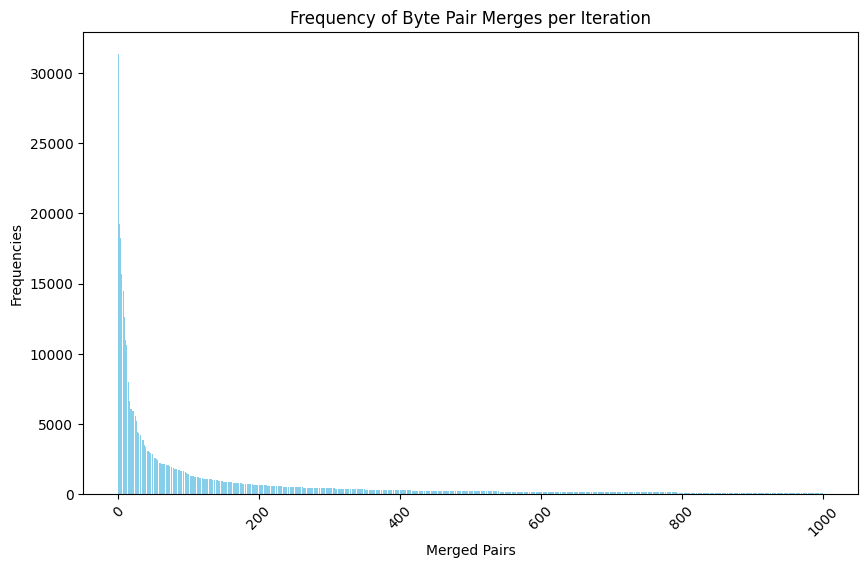

In [86]:
books_bpe.visualize_pair_merge_freq()